In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Load Datasets

## Load Train Data

In [2]:
df_train = pd.read_csv('Datasets/train.csv')
df_train

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,...,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived


In [3]:
df_train.drop('id',inplace=True,axis=1)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null   object 
 15  naso

## Load Test Data

In [5]:
df_test = pd.read_csv('Datasets/test.csv')
df_test

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,1235,no,adult,534053,38.6,40.0,20.0,normal,normal,normal_pink,...,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
1,1236,yes,adult,528469,38.2,112.0,48.0,cool,reduced,bright_pink,...,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
2,1237,yes,adult,528178,37.7,66.0,12.0,cool,normal,bright_red,...,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
3,1238,no,adult,534784,37.1,88.0,20.0,cool,reduced,pale_cyanotic,...,distend_large,75.0,81.0,NaN,1.0,yes,1400,0,0,no
4,1239,yes,adult,529840,38.3,50.0,12.0,NaN,normal,bright_pink,...,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,no,adult,529461,40.3,114.0,36.0,cool,reduced,normal_pink,...,distend_large,57.0,8.1,serosanguious,4.5,yes,3205,0,0,yes
820,2055,yes,adult,535338,37.2,100.0,20.0,cool,reduced,pale_cyanotic,...,distend_small,50.0,66.0,serosanguious,2.0,yes,2209,0,0,no
821,2056,yes,adult,529640,39.2,132.0,12.0,cool,reduced,dark_cyanotic,...,NaN,53.0,7.6,serosanguious,4.5,yes,2205,0,0,no
822,2057,no,adult,5287179,38.3,54.0,66.0,normal,normal,normal_pink,...,NaN,49.0,8.6,clear,5.0,no,3111,0,0,yes


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     824 non-null    int64  
 1   surgery                824 non-null    object 
 2   age                    824 non-null    object 
 3   hospital_number        824 non-null    int64  
 4   rectal_temp            824 non-null    float64
 5   pulse                  824 non-null    float64
 6   respiratory_rate       824 non-null    float64
 7   temp_of_extremities    789 non-null    object 
 8   peripheral_pulse       777 non-null    object 
 9   mucous_membrane        811 non-null    object 
 10  capillary_refill_time  818 non-null    object 
 11  pain                   795 non-null    object 
 12  peristalsis            805 non-null    object 
 13  abdominal_distention   802 non-null    object 
 14  nasogastric_tube       760 non-null    object 
 15  nasoga

# Data Preprocessing

- ## Handle Missing Value

In [7]:
def handle_missing_value(df: pd.DataFrame):
    for i in df.columns:
        if pd.api.types.is_numeric_dtype(df[i].dtype):
            df[i].fillna(df[i].mean(),inplace=True)
        else:
            df[i].fillna(df[i].mode()[0],inplace=True)

In [8]:
handle_missing_value(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1235 non-null   object 
 7   peripheral_pulse       1235 non-null   object 
 8   mucous_membrane        1235 non-null   object 
 9   capillary_refill_time  1235 non-null   object 
 10  pain                   1235 non-null   object 
 11  peristalsis            1235 non-null   object 
 12  abdominal_distention   1235 non-null   object 
 13  nasogastric_tube       1235 non-null   object 
 14  nasogastric_reflux     1235 non-null   object 
 15  naso

In [9]:
handle_missing_value(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     824 non-null    int64  
 1   surgery                824 non-null    object 
 2   age                    824 non-null    object 
 3   hospital_number        824 non-null    int64  
 4   rectal_temp            824 non-null    float64
 5   pulse                  824 non-null    float64
 6   respiratory_rate       824 non-null    float64
 7   temp_of_extremities    824 non-null    object 
 8   peripheral_pulse       824 non-null    object 
 9   mucous_membrane        824 non-null    object 
 10  capillary_refill_time  824 non-null    object 
 11  pain                   824 non-null    object 
 12  peristalsis            824 non-null    object 
 13  abdominal_distention   824 non-null    object 
 14  nasogastric_tube       824 non-null    object 
 15  nasoga

- ## Label Encoding

In [10]:
df_train.outcome.value_counts()

outcome
lived         574
died          410
euthanized    251
Name: count, dtype: int64

In [11]:
# Encode Binary Data
df_train['surgery'].replace({'yes':1,'no':0},inplace=True)
df_train['age'].replace({'adult':1,'young':0},inplace=True)
df_train['surgical_lesion'].replace({'yes':1,'no':0},inplace=True)
df_train['cp_data'].replace({'yes':1,'no':0},inplace=True)
df_test['surgery'].replace({'yes':1,'no':0},inplace=True)
df_test['age'].replace({'adult':1,'young':0},inplace=True)
df_test['surgical_lesion'].replace({'yes':1,'no':0},inplace=True)
df_test['cp_data'].replace({'yes':1,'no':0},inplace=True)

# Encode Ordinal Data
df_train['temp_of_extremities'].replace({'cold':3,'cool':2,'normal':1,'warm':0},inplace=True)
df_train['peripheral_pulse'].replace({'reduced':3,'normal':2,'absent':1,'increased':0},inplace=True)
df_train['capillary_refill_time'].replace({'less_3_sec':1,'more_3_sec':2,'3':0},inplace=True)
df_train['pain'].replace({'extreme_pain': 4, 'severe_pain': 3, 'moderate': 2, 'depressed': 1, 'mild_pain': 1, 'slight': 0, 'alert': 0}, inplace=True)
df_train['peristalsis'].replace({'absent': 0, 'distend_small': 1, 'hypomotile': 2, 'normal': 3, 'hypermotile': 4}, inplace=True)
df_train['abdominal_distention'].replace({'none':0,'slight':1,'moderate':2,'severe':3},inplace=True)
df_train['nasogastric_tube'].replace({'none':0,'slight':1,'significant':2},inplace=True)
df_train['nasogastric_reflux'].replace({'none':0,'slight':1,'less_1_liter':2,'more_1_liter':3},inplace=True)
df_train['rectal_exam_feces'].replace({'absent':0,'decreased':1,'normal':2,'increased':3,'serosanguious':3},inplace=True)
df_train['abdomen'].replace({'normal':0,'firm':1,'distend_small':2,'distend_large':3,'other':0},inplace=True)
df_train['abdomo_appearance'].replace({'clear':0,'cloudy':1,'serosanguious':2},inplace=True)
df_train['mucous_membrane'].replace({'normal_pink':0,'bright_pink':1,'pale_pink':2,'pale_cyanotic':3,'bright_red':4,'dark_cyanotic':5},inplace=True)

df_train['outcome'].replace({'died':0, 'euthanized':1, 'lived':2},inplace=True)

df_test['temp_of_extremities'].replace({'cold':3,'cool':2,'normal':1,'warm':0},inplace=True)
df_test['peripheral_pulse'].replace({'reduced':3,'normal':2,'absent':1,'increased':0},inplace=True)
df_test['capillary_refill_time'].replace({'less_3_sec':1,'more_3_sec':2,'3':0},inplace=True)
df_test['pain'].replace({'extreme_pain': 4, 'severe_pain': 3, 'moderate': 2, 'depressed': 1, 'mild_pain': 1, 'slight': 0, 'alert': 0}, inplace=True)
df_test['peristalsis'].replace({'absent': 0, 'distend_small': 1, 'hypomotile': 2, 'normal': 3, 'hypermotile': 4}, inplace=True)
df_test['abdominal_distention'].replace({'none':0,'slight':1,'moderate':2,'severe':3},inplace=True)
df_test['nasogastric_tube'].replace({'none':0,'slight':1,'significant':2},inplace=True)
df_test['nasogastric_reflux'].replace({'none':0,'slight':1,'less_1_liter':2,'more_1_liter':3},inplace=True)
df_test['rectal_exam_feces'].replace({'absent':0,'decreased':1,'normal':2,'increased':3,'serosanguious':3},inplace=True)
df_test['abdomen'].replace({'normal':0,'firm':1,'distend_small':2,'distend_large':3,'other':0},inplace=True)
df_test['abdomo_appearance'].replace({'clear':0,'cloudy':1,'serosanguious':2},inplace=True)
df_test['mucous_membrane'].replace({'normal_pink':0,'bright_pink':1,'pale_pink':2,'pale_cyanotic':3,'bright_red':4,'dark_cyanotic':5},inplace=True)

df_train

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,1,1,530001,38.1,132.0,24.0,2,3,5,2,...,57.0,8.5,2,3.4,1,2209,0,0,0,0
1,1,1,533836,37.5,88.0,12.0,2,2,3,2,...,33.0,64.0,2,2.0,1,2208,0,0,0,1
2,1,1,529812,38.3,120.0,28.0,2,3,2,1,...,37.0,6.4,2,3.4,1,5124,0,0,0,2
3,1,1,5262541,37.1,72.0,30.0,3,3,2,2,...,53.0,7.0,1,3.9,1,2208,0,0,1,2
4,0,1,5299629,38.0,52.0,48.0,1,2,0,1,...,47.0,7.3,1,2.6,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1,1,535246,38.5,129.0,48.0,2,3,2,2,...,57.0,66.0,2,2.0,1,2206,0,0,0,2
1231,1,1,528570,37.5,60.0,50.0,2,3,3,1,...,35.0,6.4,2,3.6,1,2209,0,0,1,0
1232,1,0,529685,37.5,84.0,40.0,1,3,0,1,...,40.0,5.9,1,7.0,1,400,0,0,1,2
1233,1,1,534784,38.1,70.0,16.0,1,3,4,1,...,58.0,74.0,1,2.0,1,2209,0,0,0,2


- ## Data Visualization

In [12]:
df_train.describe()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
count,1235.000000,1235.000000,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,...,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,0.718219,0.939271,9.545004e+05,38.202186,79.574089,30.054251,1.753036,2.613765,2.345749,1.316599,...,49.602429,21.388016,1.291498,3.290931,0.752227,3832.496356,14.612146,3.577328,0.540891,1.132794
std,0.450050,0.238929,1.356403e+06,0.788668,29.108638,16.452066,0.681830,0.534670,1.601095,0.468808,...,10.535800,26.676453,0.790472,1.589195,0.431894,5436.733774,193.705735,88.858953,0.498527,0.883039
min,0.000000,0.000000,5.213990e+05,35.400000,30.000000,8.000000,0.000000,0.000000,0.000000,0.000000,...,23.000000,3.500000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,5.288000e+05,37.800000,53.000000,18.000000,1.000000,2.000000,1.000000,1.000000,...,43.000000,6.600000,1.000000,2.000000,1.000000,2205.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,5.297770e+05,38.200000,76.000000,28.000000,2.000000,3.000000,2.000000,1.000000,...,48.000000,7.500000,2.000000,3.000000,1.000000,2209.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,5.341450e+05,38.600000,100.000000,36.000000,2.000000,3.000000,4.000000,2.000000,...,57.000000,9.100000,2.000000,4.300000,1.000000,3205.000000,0.000000,0.000000,1.000000,2.000000
max,1.000000,1.000000,5.305129e+06,40.800000,184.000000,96.000000,3.000000,3.000000,5.000000,2.000000,...,75.000000,89.000000,2.000000,10.100000,1.000000,41110.000000,3112.000000,2209.000000,1.000000,2.000000


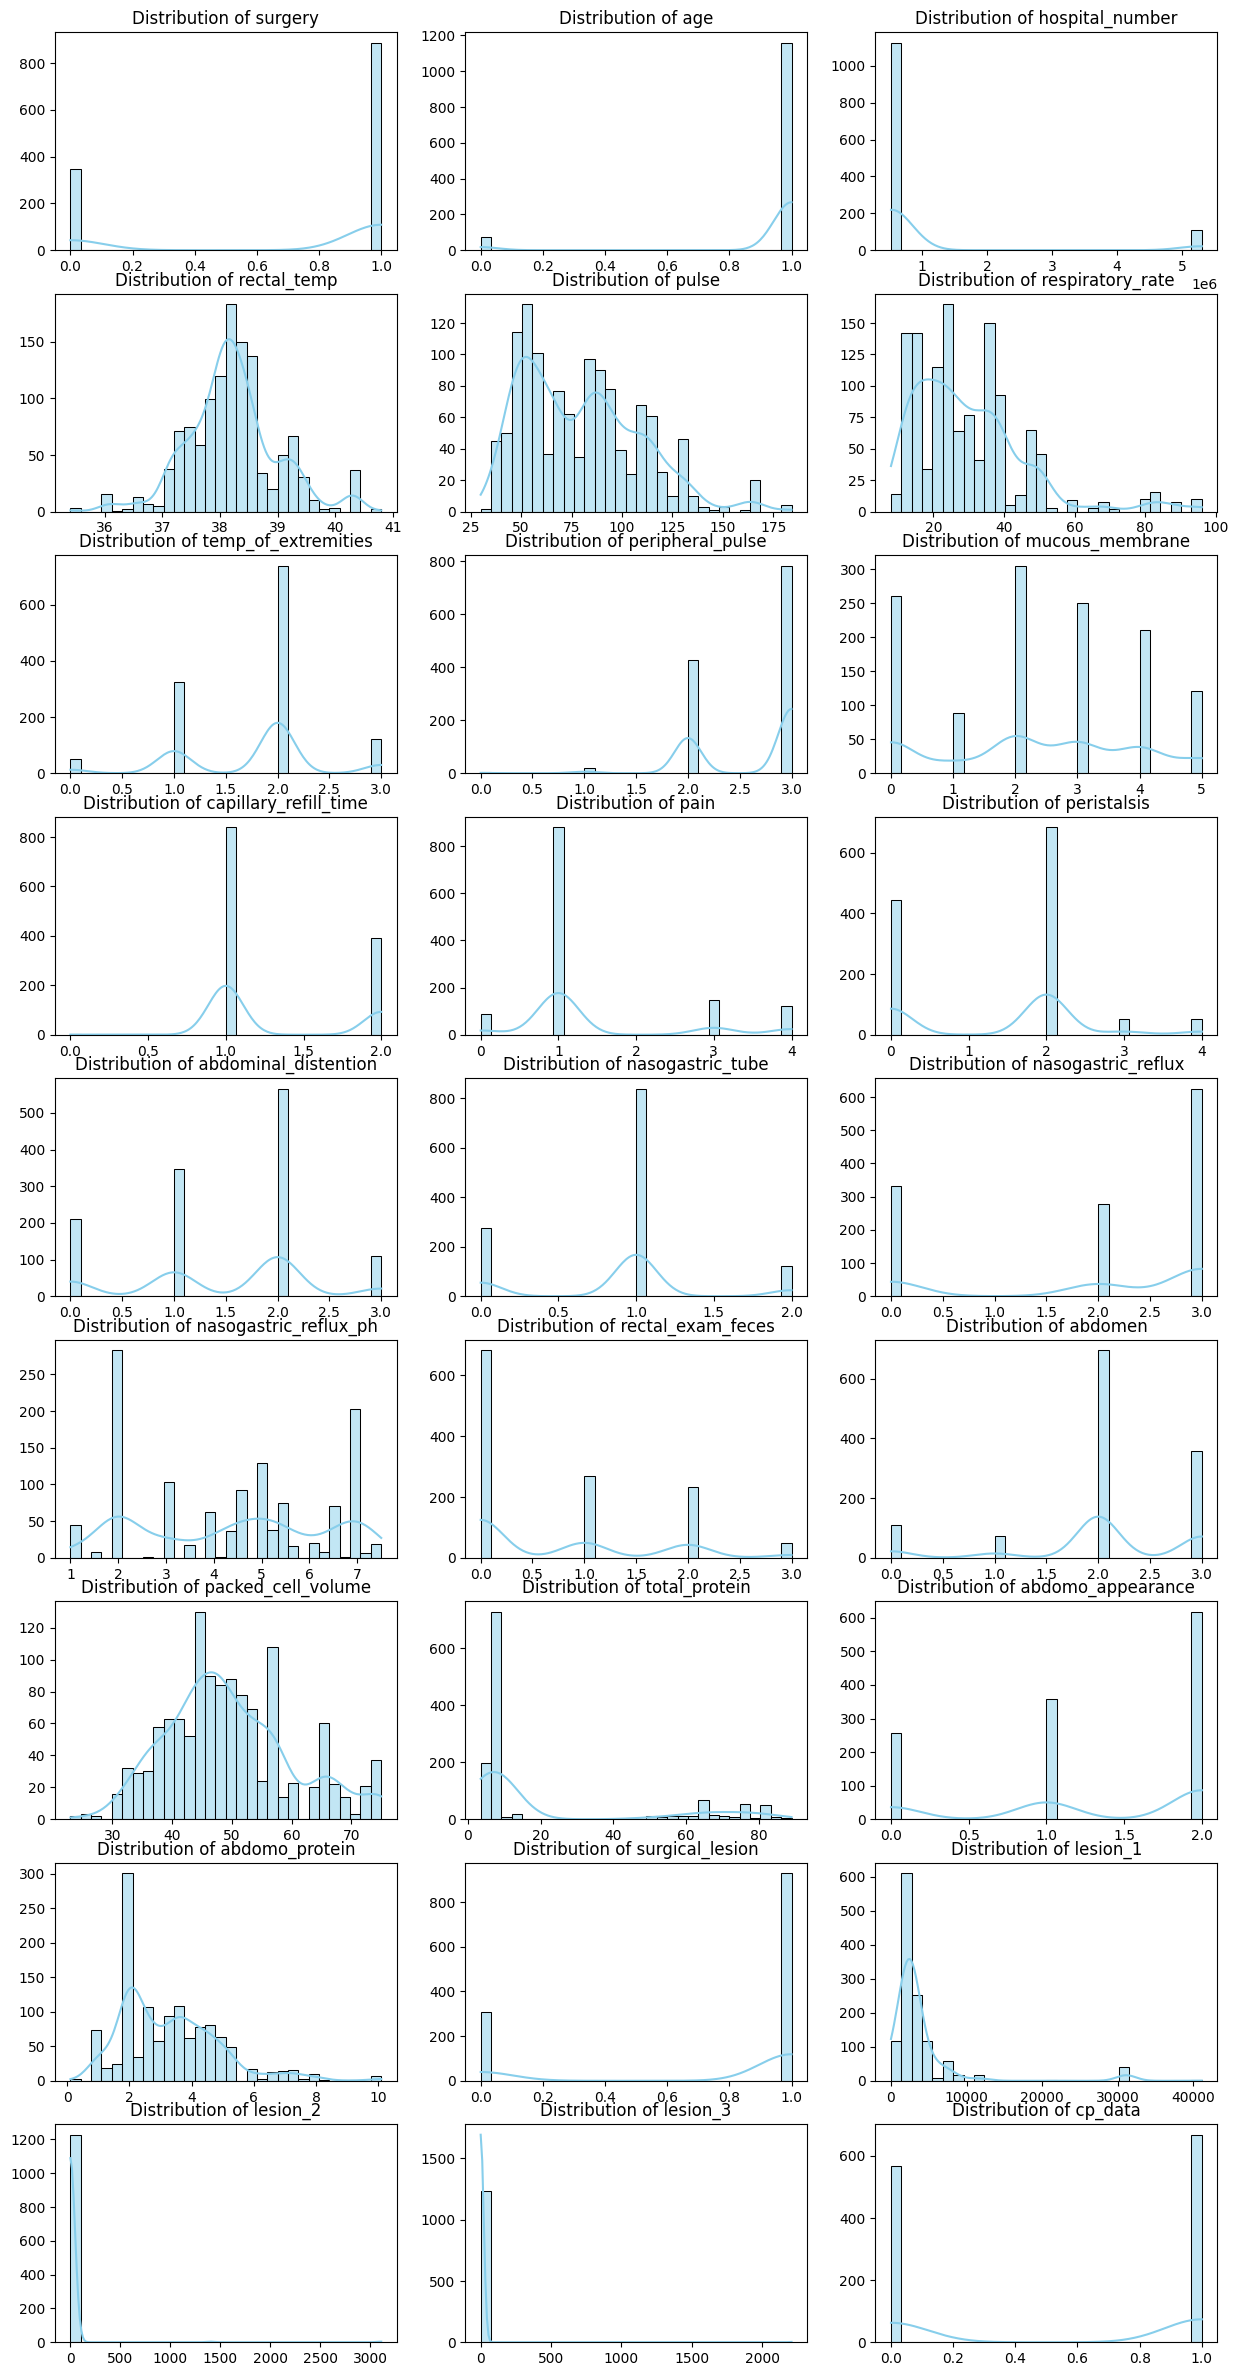

In [13]:
fig, axes = plt.subplots(9, 3, figsize=(15, 30))
axes = axes.flatten()

for i, (col, ax) in enumerate(zip(df_train.columns[:-1], axes)):
    sns.histplot(df_train[col], ax=ax, kde=True, color='skyblue', bins=30)
    ax.set_title(f'Distribution of {col}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')

- ## Building Model

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(df_train.iloc[:,:-1],df_train.iloc[:,-1],test_size=0.1,random_state=42,stratify=df_train.iloc[:,-1])
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
temp = []

- ### Naive Bayes

In [17]:
multinomial_nb = MultinomialNB()
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
grid_search = GridSearchCV(estimator=multinomial_nb,param_grid=param_grid,cv=skf,scoring='f1_micro')
grid_search.fit(X_train,y_train)
temp.append(('MultinomialNB', grid_search.best_score_, grid_search.best_params_))

In [18]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/multinomialNB_submission.csv',index=False)

C:\Users\jayaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


In [19]:
gaussian_nb = GaussianNB()
temp.append(('GaussianNB', cross_val_score(gaussian_nb, X_train, y_train, cv=skf).mean(), gaussian_nb.get_params()))

In [20]:
gaussian_nb.fit(X_train,y_train)
y_pred = gaussian_nb.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/gaussianNB_submission.csv',index=False)

C:\Users\jayaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


- ### SVM

In [21]:
svm = SVC()
temp.append(('SVM',cross_val_score(svm,X_train,y_train,cv=skf).mean(), svm.get_params))

In [22]:
svm.fit(X_train,y_train)
y_pred = svm.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/SVM_submission.csv',index=False)

C:\Users\jayaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


- ### KNN

In [23]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan'],
}
grid_search = GridSearchCV(knn,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train.values,y_train.values)
temp.append(('KNN',grid_search.best_score_,grid_search.best_params_))

In [24]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/KNN_submission.csv',index=False)

- ### XGBoost

In [25]:
xgb = XGBClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
}
grid_search = GridSearchCV(xgb,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('XGBoost',grid_search.best_score_,grid_search.best_params_))

In [26]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/XGBoost_submission.csv',index=False)

- ### CatBoost

In [27]:
cat = CatBoostClassifier()
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
}
grid_search = GridSearchCV(cat,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('CatBoost',grid_search.best_score_,grid_search.best_params_))

0:	learn: 1.0941401	total: 171ms	remaining: 17s
1:	learn: 1.0885959	total: 175ms	remaining: 8.59s
2:	learn: 1.0834142	total: 179ms	remaining: 5.79s
3:	learn: 1.0790859	total: 183ms	remaining: 4.39s
4:	learn: 1.0741271	total: 187ms	remaining: 3.54s
5:	learn: 1.0690803	total: 191ms	remaining: 2.99s
6:	learn: 1.0639534	total: 194ms	remaining: 2.58s
7:	learn: 1.0599053	total: 199ms	remaining: 2.29s
8:	learn: 1.0551415	total: 202ms	remaining: 2.05s
9:	learn: 1.0502356	total: 209ms	remaining: 1.88s
10:	learn: 1.0464618	total: 212ms	remaining: 1.72s
11:	learn: 1.0417948	total: 217ms	remaining: 1.59s
12:	learn: 1.0371137	total: 222ms	remaining: 1.48s
13:	learn: 1.0328487	total: 225ms	remaining: 1.38s
14:	learn: 1.0292382	total: 228ms	remaining: 1.29s
15:	learn: 1.0251759	total: 233ms	remaining: 1.22s
16:	learn: 1.0205707	total: 236ms	remaining: 1.15s
17:	learn: 1.0167130	total: 239ms	remaining: 1.09s
18:	learn: 1.0127471	total: 243ms	remaining: 1.03s
19:	learn: 1.0086734	total: 247ms	remaining

In [28]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred.flatten)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/CatBoost_submission.csv',index=False)

- ### LightGBM

In [29]:
lgb_model = lgb.LGBMClassifier()
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [-1, 5, 10],
}
grid_search = GridSearchCV(lgb_model,param_grid=param_grid,cv=skf,scoring='f1_micro')
grid_search.fit(X_train,y_train)
temp.append(('LightGBM',grid_search.best_score_,grid_search.best_params_))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 25
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -1.597365
[LightGBM] [Info] Start training from score -0.764456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 25
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -1.592378
[LightGBM] [Info] Start training from score -0.766632
[LightGBM] [Info] Auto-choosing row-wise

In [30]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/LightGBM_submission.csv',index=False)

- ### Logistic Regression

In [31]:
logistic = LogisticRegression()
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(logistic,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('Logistic Regression',grid_search.best_score_,grid_search.best_params_))

C:\Users\jayaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jayaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

In [32]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/LogisticRegression_submission.csv',index=False)

C:\Users\jayaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


- ### Decision Tree

In [33]:
decision_tree = DecisionTreeClassifier()
param_grid = {
    'max_depth': [None, 5, 10, 20], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2', None]
}
grid_search = GridSearchCV(decision_tree,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('Decision Tree',grid_search.best_score_,grid_search.best_params_))

In [34]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/DecisionTree_submission.csv',index=False)

C:\Users\jayaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


- ### Random Forest

In [35]:
random_forest = RandomForestClassifier()
param_grid = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 5, 10, 20], 
}
grid_search = GridSearchCV(random_forest,param_grid=param_grid,cv=skf,scoring='f1_micro',error_score='raise')
grid_search.fit(X_train,y_train)
temp.append(('Random Forest',grid_search.best_score_,grid_search.best_params_))

In [36]:
y_pred = grid_search.best_estimator_.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/RandomForest_submission.csv',index=False)

C:\Users\jayaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


- ### Model Ensembling 

Pada model ensembling, model yang digunakan adalah CatBoost, XGBoost, dan Random Forest

In [41]:
# warnings.filterwarnings('ignore')
clf1 = CatBoostClassifier(iterations=200,learning_rate=0.05)
clf2 = XGBClassifier(n_estimators=200,learning_rate=0.01)
clf3 = RandomForestClassifier(max_depth=10,n_estimators=200)
clf4 = lgb.LGBMClassifier(learning_rate=0.1,max_depth=-1,num_leaves=20)
clf = VotingClassifier(estimators=[('CatBoost', clf1), ('XGBoost', clf2), ('Random Forest', clf3), ('LightGBM', clf4)], voting='soft',flatten_transform=True)
clf.fit(X_train,y_train)
temp.append(('Voting Classifier',cross_val_score(clf,X_train,y_train,cv=skf, error_score='raise').mean(), clf.get_params()))

0:	learn: 1.0773811	total: 6.89ms	remaining: 1.37s
1:	learn: 1.0521627	total: 12.9ms	remaining: 1.28s
2:	learn: 1.0283154	total: 16.3ms	remaining: 1.07s
3:	learn: 1.0111835	total: 20.1ms	remaining: 983ms
4:	learn: 0.9908161	total: 23.5ms	remaining: 918ms
5:	learn: 0.9737837	total: 29.7ms	remaining: 961ms
6:	learn: 0.9554512	total: 33.8ms	remaining: 931ms
7:	learn: 0.9421822	total: 37.1ms	remaining: 891ms
8:	learn: 0.9287275	total: 43.7ms	remaining: 928ms
9:	learn: 0.9156163	total: 47.7ms	remaining: 907ms
10:	learn: 0.9038848	total: 51.2ms	remaining: 880ms
11:	learn: 0.8915832	total: 55ms	remaining: 861ms
12:	learn: 0.8787600	total: 61.5ms	remaining: 885ms
13:	learn: 0.8673627	total: 65.1ms	remaining: 865ms
14:	learn: 0.8579259	total: 69ms	remaining: 851ms
15:	learn: 0.8475851	total: 75.4ms	remaining: 867ms
16:	learn: 0.8377611	total: 78.9ms	remaining: 849ms
17:	learn: 0.8295213	total: 82.2ms	remaining: 831ms
18:	learn: 0.8212867	total: 85.7ms	remaining: 817ms
19:	learn: 0.8135676	total

In [42]:
y_pred = clf.predict(df_test.iloc[:,1:].values)
y_pred = pd.Series(y_pred)
y_pred.replace({0:'died',1:'euthanized',2:'lived'},inplace=True)
submission = pd.concat([df_test['id'],pd.DataFrame(y_pred)],axis=1)
submission.to_csv('Submission/VotingClassifier_submission.csv',index=False)

C:\Users\jayaw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [43]:
temp = sorted(temp, key= lambda x: x[1], reverse=True)
temp

[('LightGBM',
  0.7190283400809717,
  {'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 20}),
 ('Voting Classifier',
  0.7157894736842106,
  {'estimators': [('CatBoost',
     <catboost.core.CatBoostClassifier at 0x256b3b0ab30>),
    ('XGBoost',
     XGBClassifier(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None, early_stopping_rounds=None,
                   enable_categorical=False, eval_metric=None, feature_types=None,
                   gamma=None, grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.01, max_bin=None,
                   max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=None, max_leaves=None,
                   min_child_weight=None, missing=nan, monotone_constraints=None,
                   multi_strategy=None, n_estimators=200, n_jobs=None,
      